### <center> Adaptive Technique for Particle MCMC used in the Chopin Repo


The Chopin repo, "particles" uses a technique for adapting the state of the Markov Chain they call vanishing adaptation. I haven't been able to find a source yet but empirically it appears to perform well and particles has the most robust implementation of PMMH I'm aware of. 

All of the below can be found in [github link to mcmc.py](https://github.com/nchopin/particles/blob/master/particles/mcmc.py), in the PMMH sampler class and the covariance tracker. 

Examining the behavior in the class VanishCovTracker, the running estimate of the covariance given the chain is computed, the initial covariance in self.Sigma0 is user defined and defaults to the identity matrix. 

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import cholesky

In [6]:
'''Pasted the class from the repo here to examine the components. '''

class VanishCovTracker:
    r"""Tracks the vanishing mean and covariance of a sequence of points.

    Computes running mean and covariance of points
    t^(-alpha) * X_t
    for some alpha \in [0,1] (typically)
    """

    def __init__(self, alpha=0.6, dim=1, mu0=None, Sigma0=None):
        self.alpha = alpha
        self.t = 0
        self.mu = np.zeros(dim) if mu0 is None else mu0
        if Sigma0 is None:
            self.Sigma = np.eye(dim)
            self.L0 = np.eye(dim) #L0 is the cholesky decomposition of the covariance which can be used in computing normal distributions by hand
        else:
            self.Sigma = Sigma0
            self.L0 = cholesky(Sigma0, lower=True)
        self.L = self.L0.copy()

    def gamma(self):
        return (self.t + 1) ** (-self.alpha)  # not t, otherwise gamma(1)=1.

    def update(self, v):
        """Adds point v"""
        self.t += 1
        g = self.gamma()
        self.mu = (1.0 - g) * self.mu + g * v
        mv = v - self.mu
        self.Sigma = (1.0 - g) * self.Sigma + g * np.dot(
            mv[:, np.newaxis], mv[np.newaxis, :]
        )
        try:
            self.L = cholesky(self.Sigma, lower=True)
        except LinAlgError:
            self.L = self.L0



The running covariance is set recursively in update. First t is incremented, which would correspond to the iteration count in the mcmc chain, then a parameter $\mu$ is computed. 

$$
g = (t + 1)^{-\alpha} \\
\mu = (1 - g)\mu + g v
$$

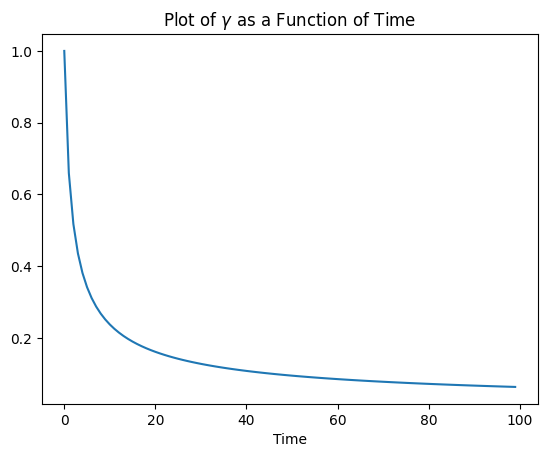

In [20]:
def gamma(t,alpha):
        return (t + 1) ** (-alpha)  # not t, otherwise gamma(1)=1.

t = np.arange(0,100)

plt.title("Plot of $\\gamma$ as a Function of Time")
plt.xlabel("Time")
plt.plot(t,gamma(t,0.6))

In [18]:
'''The quantity to be added to the chain is shifted by mu before the covariance is computed. Mu is user specified and defaults to a vector of zeros, 
then follows the recursive formula above.'''

sigma = np.eye(3)
mu = np.array([0.8,1.1,0.8])
v = np.array([1.,2.,0.5])

mv = v - mu
sigma = (1 - gamma(0,0.6)) * sigma + gamma(0,0.6) * np.outer(mv,mv.T)

print(sigma)


[[ 0.04  0.18 -0.06]
 [ 0.18  0.81 -0.27]
 [-0.06 -0.27  0.09]]
